In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils_cd import (
        split_dataset,
        standard_deviation,
        plot_comparison_results,
        impute_values,
        plot_results,
        plot_param_improv
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Normalizer, StandardScaler
from imblearn.over_sampling import SMOTE

pd.options.display.max_columns = None
sns.set(style='darkgrid')
CLASS = 'consensus'

In [19]:
green_data = pd.read_csv('green.csv')
hinselmann_data = pd.read_csv('hinselmann.csv')
schiller_data = pd.read_csv('schiller.csv')

In [21]:
expert_columns = ['experts::{}'.format(i) for i in range(6)]
green = green_data.drop(columns=expert_columns)
hinselmann = hinselmann_data.drop(columns=expert_columns)
schiller = schiller_data.drop(columns=expert_columns)
coloscopies = pd.concat([green, hinselmann, schiller])

The dataset is divided into 3 modalities: green, hinselmann and schiller. There are 7 target variables which consist of 6 experts (X 0..6) and a consensus. The target variables can take 2 values 0 for bad and 1 for good.
We should analyze how each expert evaluates each colposcopy and if they are usually right with the consensus? First we are going to analyze this without the experts attributes

In [22]:
coloscopies.head()

,cervix_area,os_area,walls_area,speculum_area,artifacts_area,cervix_artifacts_area,os_artifacts_area,walls_artifacts_area,speculum_artifacts_area,cervix_specularities_area,os_specularities_area,walls_specularities_area,speculum_specularities_area,specularities_area,area_h_max_diff,rgb_cervix_r_mean,rgb_cervix_r_std,rgb_cervix_r_mean_minus_std,rgb_cervix_r_mean_plus_std,rgb_cervix_g_mean,rgb_cervix_g_std,rgb_cervix_g_mean_minus_std,rgb_cervix_g_mean_plus_std,rgb_cervix_b_mean,rgb_cervix_b_std,rgb_cervix_b_mean_minus_std,rgb_cervix_b_mean_plus_std,rgb_total_r_mean,rgb_total_r_std,rgb_total_r_mean_minus_std,rgb_total_r_mean_plus_std,rgb_total_g_mean,rgb_total_g_std,rgb_total_g_mean_minus_std,rgb_total_g_mean_plus_std,rgb_total_b_mean,rgb_total_b_std,rgb_total_b_mean_minus_std,rgb_total_b_mean_plus_std,hsv_cervix_h_mean,hsv_cervix_h_std,hsv_cervix_s_mean,hsv_cervix_s_std,hsv_cervix_v_mean,hsv_cervix_v_std,hsv_total_h_mean,hsv_total_h_std,hsv_total_s_mean,hsv_total_s_std,hsv_total_v_mean,hsv_total_v_std,fit_cervix_hull_rate,fit_cervix_hull_total,fit_cervix_bbox_rate,fit_cervix_bbox_total,fit_circle_rate,fit_circle_total,fit_ellipse_rate,fit_ellipse_total,fit_ellipse_goodness,dist_to_center_cervix,dist_to_center_os,consensus
0,0.344647,0.003080,0.047522,0.288216,0.178585,0.016564,0.0,0.043500,0.010149,0.000133,0.0,0.000000,0.085833,0.024907,0.263560,37.594458,15.785021,21.809437,53.379479,109.918445,38.735421,71.183024,148.653865,55.029618,22.160330,32.869287,77.189948,38.561367,38.119059,0.442308,76.680426,95.109755,51.565052,43.544702,146.674807,48.808474,40.765228,8.043247,89.573702,5.014628,2.991944,167.952780,25.813163,109.919447,38.733741,5.090801,2.936650,159.486916,38.437294,95.123889,51.583029,0.923067,0.373371,0.844454,0.408130,0.603399,0.571175,0.962995,0.357890,85.474311,0.265933,0.346294,1.0
1,0.165329,0.000000,0.048236,0.504736,0.502783,0.007012,0.0,0.097405,0.973837,0.004055,0.0,0.000000,0.054999,0.028431,0.000000,59.505882,24.361877,35.144005,83.867760,122.366075,44.742407,77.623669,167.108482,78.058434,30.818729,47.239706,108.877163,54.932467,39.447415,15.485052,94.379883,101.680459,46.028852,55.651607,147.709311,63.218931,43.925912,19.293019,107.144843,4.944382,2.965108,130.260492,24.143867,122.366647,44.743932,5.080063,2.894163,128.251978,33.000693,101.725519,46.093510,0.850861,0.194308,0.646645,0.255673,0.497315,0.332444,0.894625,0.184803,124.794129,1.000000,0.283059,0.0
2,0.457010,0.001681,0.242888,0.212859,0.000000,0.000000,0.0,0.000000,0.000000,0.001756,0.0,0.000000,0.083055,0.018591,0.269798,39.353851,19.417332,19.936519,58.771183,109.543386,49.753490,59.789896,159.296876,54.642888,27.781965,26.860923,82.424853,41.242230,34.196356,7.045875,75.438586,109.592342,57.576640,52.015702,167.168982,53.470241,38.344391,15.125850,91.814632,5.049946,2.983966,163.576979,24.973042,109.544201,49.753659,5.078936,2.968023,162.268659,33.590792,109.597127,57.584515,0.918514,0.497554,0.747443,0.611432,0.633925,0.720923,0.920287,0.496596,94.948697,0.518740,0.419375,0.0
3,0.513244,0.005711,0.213781,0.251819,0.079795,0.000000,0.0,0.017594,0.007208,0.001288,0.0,0.000315,0.000000,0.000729,0.107022,46.322391,17.711957,28.610434,64.034349,116.075087,43.593124,72.481962,159.668211,51.430923,18.573016,32.857907,70.003940,40.365565,17.259087,23.106478,57.624652,102.641859,38.606995,64.034863,141.248854,50.805205,18.072101,32.733104,68.877306,5.177654,2.969214,156.242754,25.499379,116.081770,43.582671,5.071879,2.909002,158.343946,28.273928,102.648278,38.598300,0.951710,0.539286,0.855409,0.599998,0.618140,0.830304,0.964611,0.532073,74.221670,0.347202,0.361672,1.0
4,0.390319,0.009454,0.272884,0.373487,0.000000,0.000000,0.0,0.000000,0.000000,0.000196,0.0,0.000304,0.071442,0.026759,0.442831,37.552979,14.454975,23.098004,52.007953,101.044906,37.171973,63.872932,138.216879,53.971671,17.591669,36.380003,71.563340,40.717229,38.810699,1.906530,79.527927,97.446185,48.106253,49.339932,145.552438,51.733004,39.866956,11.866047,91.599960,4.978534,2.964

In [23]:
coloscopies.describe()

,cervix_area,os_area,walls_area,speculum_area,artifacts_area,cervix_artifacts_area,os_artifacts_area,walls_artifacts_area,speculum_artifacts_area,cervix_specularities_area,os_specularities_area,walls_specularities_area,speculum_specularities_area,specularities_area,area_h_max_diff,rgb_cervix_r_mean,rgb_cervix_r_std,rgb_cervix_r_mean_minus_std,rgb_cervix_r_mean_plus_std,rgb_cervix_g_mean,rgb_cervix_g_std,rgb_cervix_g_mean_minus_std,rgb_cervix_g_mean_plus_std,rgb_cervix_b_mean,rgb_cervix_b_std,rgb_cervix_b_mean_minus_std,rgb_cervix_b_mean_plus_std,rgb_total_r_mean,rgb_total_r_std,rgb_total_r_mean_minus_std,rgb_total_r_mean_plus_std,rgb_total_g_mean,rgb_total_g_std,rgb_total_g_mean_minus_std,rgb_total_g_mean_plus_std,rgb_total_b_mean,rgb_total_b_std,rgb_total_b_mean_minus_std,rgb_total_b_mean_plus_std,hsv_cervix_h_mean,hsv_cervix_h_std,hsv_cervix_s_mean,hsv_cervix_s_std,hsv_cervix_v_mean,hsv_cervix_v_std,hsv_total_h_mean,hsv_total_h_std,hsv_total_s_mean,hsv_total_s_std,hsv_total_v_mean,hsv_total_v_std,fit_cervix_hull_rate,fit_cervix_hull_total,fit_cervix_bbox_rate,fit_cervix_bbox_total,fit_circle_rate,fit_circle_total,fit_ellipse_rate,fit_ellipse_total,fit_ellipse_goodness,dist_to_center_cervix,dist_to_center_os,consensus
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,0.477013,0.007368,0.172563,0.235195,0.047354,0.031741,0.051262,0.041739,0.018311,0.014400,0.012181,0.008781,0.083601,0.031248,0.196742,75.198745,33.046061,42.152684,108.244806,79.459880,34.565994,44.893886,114.025873,97.929804,39.466866,58.462938,137.396670,72.469339,47.439715,25.029624,119.909054,77.472621,48.758443,28.714178,126.231064,88.271212,53.153130,35.118081,141.424342,4.532769,2.746939,145.503441,35.048319,124.136695,46.442824,4.534511,2.707917,138.736802,46.294892,112.927822,61.643427,0.915829,0.500141,0.786685,0.577768,0.587217,0.800333,0.942705,0.484914,133.914046,0.479419,0.435682,0.752613
std,0.223491,0.005986,0.188248,0.174551,0.065196,0.061481,0.158501,0.110074,0.091990,0.029968,0.052387,0.034504,0.114312,0.037532,0.136503,48.166040,15.707880,40.186336,59.316677,51.018551,16.073230,42.030691,62.895974,64.683745,21.149424,51.958875,81.011390,34.338149,19.901635,25.194989,50.155554,34.172702,20.539788,25.094970,50.493121,49.441108,22.976548,34.889056,68.756407,0.696035,0.551488,54.708605,19.041504,58.188115,18.734886,0.645581,0.244458,54.326386,19.428641,37.683655,18.814282,0.171820,0.220632,0.165678,0.232471,0.131334,0.402581,0.176780,0.211091,90.492877,0.238634,0.162610,0.432247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.017678,0.000000,0.000000,0.000000,-21.587384,0.000000,0.000000,0.000000,-24.334970,0.000000,0.168630,2.787604,-16.189196,2.956234,0.341837,4.276427,-15.341175,4.618264,0.181047,2.973292,-25.284722,3.154339,3.141593,0.000000,0.000000,0.000000,0.000000,0.000000,3.155260,1.795977,8.012986,16.080708,0.378291,4.323202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091654,0.084065,0.000000
25%,0.340607,0.003323,0.053151,0.079780,0.000000,0.000000,0.000000,0.000000,0.000000,0.001825,0.000000,0.000000,0.000000,0.003184,0.092591,34.496634,22.369140,8.413342,58.667212,41.497873,23.134210,13.934702,70.741515,41.944269,22.041881,16.262651,68.219836,

Let's check for the data balancing first across datasets.

NameError: name 'filename' is not defined

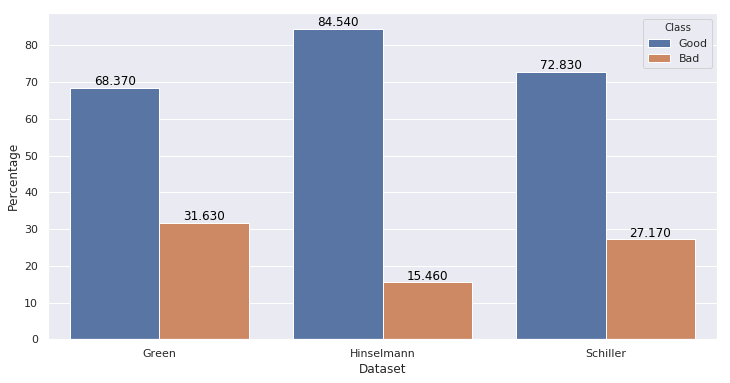

In [38]:
df_balancing = {}
i = 0
for df, name in [(green, 'Green'), (hinselmann, 'Hinselmann'), (schiller, 'Schiller')]:
    n_rows = df.shape[0]
    n_pos = df[CLASS].value_counts()[1.0]
    n_neg = df[CLASS].value_counts()[0.0]
    perc_pos = n_pos / n_rows * 100
    perc_neg = n_neg / n_rows * 100
    df_balancing[i] = {'Percentage': round(perc_pos, 2), 'Class': 'Good', 'Dataset': name}
    i += 1
    df_balancing[i] = {'Percentage': round(perc_neg, 2), 'Class': 'Bad', 'Dataset': name}
    i += 1

df_balancing = pd.DataFrame.from_dict(df_balancing, "index")
df_balancing.to_csv('plot_data/balancing.csv')
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Dataset', y='Percentage', hue='Class', data=df_balancing)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.3f}'.format(float(p.get_height())), 
        fontsize=12, color='black', ha='center', va='bottom')

plt.savefig('plots/balancing.pdf')
plt.clf()